In [1]:
# import python libraries
import cv2, os, random, importlib, numpy as np
import matplotlib.pyplot as plt 
from PIL import Image
os.chdir('../lib')

# import custom scripts 
import preprocess_images
import get_bounding_box

# reload and declare functions 
importlib.reload(preprocess_images)
importlib.reload(get_bounding_box)

from preprocess_images import preprocess_grayscale, preprocess_rgb, preprocess_rgbd
from get_bounding_box import get_bounding_box, get_bounding_box_circumscribed


The preprocess_images file as 3 functions, each cooresponding to the file type. All 3 functions are void functions that return the variables listed below. There is also an "og" (original) variable wihtin the python script that is not returned that can be used to find the unaltered image.

Ex: 

Preprocess_rgb = get all rgb image data

Preprocess_rgbd = get all image data infused with depth information on the blue color channel

Preprocess_grayscale = get all image data that is grayscale (based on depth map)

In [2]:
train_images, train_masks, val_images, val_masks, test_images, test_masks = preprocess_grayscale('../data/useable_data', 70, 15, 15)

Saving Contour Plots: 100%|██████████| 275/275 [00:22<00:00, 12.13it/s]


Number of Images: 275

Number of Train Images: 192
Number of Val Images: 41
Number of Test Images: 42


Here we are going to add images that, at an eye glance, have no tumor

Note: there is no bin files for these, so they are just rgb images put into place to increase model accuracy. They might hinder the preformace of the grayscale model

In [3]:
# add no tumor data
os.chdir('../lib')
import add_no_tumor
importlib.reload(add_no_tumor)

from add_no_tumor import add_no_tumor

train_images, train_masks, val_images, val_masks = add_no_tumor(train_images, train_masks, val_images, val_masks)


Adding images with no Tumor: 100%|██████████| 41/41 [00:00<00:00, 20481.95it/s]

New Images Added: 41

Total Training Images: 232
Total Validation Images: 82


### Sanity Check

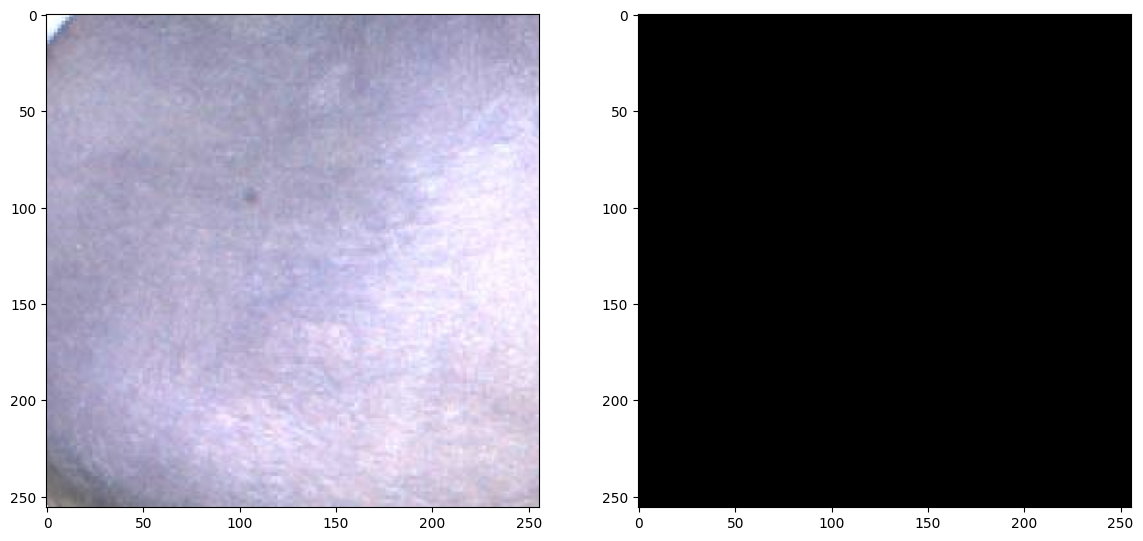

In [9]:
idx = random.randint(0, len(train_images))

fig, ax = plt.subplots(1,2, figsize=[14,14])

ax[0].imshow(train_images[idx])
ax[1].imshow(train_masks[idx], cmap="gray")

### Augmentation

In [3]:
def augment_image_array(image_array_raw, image_array_binary, num_augmentations):
    
    aug_raw = []
    aug_masks = []
    
    for _ in range(num_augmentations):
            for i in range(len(image_array_raw) -1):
                image_raw = image_array_raw[i]
                image_binary = image_array_binary[i]

                flipped_image_raw = cv2.flip(image_raw, 1)
                flipped_image_binary = cv2.flip(image_binary, 1)

                angle = random.uniform(-30, 30)
                (h, w) = flipped_image_raw.shape[:2]
                center = (w // 2, h // 2)

                M = cv2.getRotationMatrix2D(center, angle, 1.0)
                augmented_image_raw = cv2.warpAffine(flipped_image_raw, M, (w, h))
                augmented_image_binary = cv2.warpAffine(flipped_image_binary, M, (w, h))

                aug_raw.append(augmented_image_raw)
                aug_masks.append(augmented_image_binary)

    image_array_raw = np.concatenate((image_array_raw, np.array(aug_raw)))
    image_array_binary = np.concatenate((image_array_binary, np.array(aug_masks)))

    return image_array_raw, image_array_binary

In [4]:
# apply augmentation to arrays 

train_images, train_masks = augment_image_array(train_images, train_masks, 10)
val_images, val_masks = augment_image_array(val_images, val_masks, 10)
test_images, test_masks = augment_image_array(test_images, test_masks, 10)

In [5]:
# print new lengths 

print(len(train_images))
print(len(val_images))
print(len(test_images))

2102
441
452


### Create Dataset

In [6]:
# Convert the NumPy arrays to Pillow images and store them in a dictionary
training_dataset_dict = {
    "image": [Image.fromarray(img) for img in train_images],
    "label": [Image.fromarray(mask) for mask in train_masks],
}

val_dataset_dict = {
    "image": [Image.fromarray(img) for img in val_images],
    "label": [Image.fromarray(mask) for mask in val_masks],
}

In [7]:
from datasets import Dataset

# Create the dataset using the datasets.Dataset class
training_dataset = Dataset.from_dict(training_dataset_dict)
val_dataset = Dataset.from_dict(val_dataset_dict)

/home/am0532/.conda/envs/tumor-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [9]:
from transformers import SamProcessor
from torch.optim import Adam
import monai
from torch.utils.data import random_split, DataLoader
from transformers import SamModel

# import sam processor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# get an instance of SAMDataset using our training and val datasets
training_dataset = SAMDataset(dataset=training_dataset, processor=processor)
val_dataset = SAMDataset(dataset=val_dataset, processor=processor)

# dataloader 
train_dataloader = DataLoader(dataset=training_dataset, batch_size=2, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=2, shuffle=False) 

# get pretrained model that we are going to fine tune 
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

  

### Training

In [11]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceFocalLoss(sigmoid=True, squared_pred=True, reduction='mean')

100%|██████████| 1051/1051 [13:27<00:00,  1.30it/s]


EPOCH: 0
Mean training loss: 1.3094136543664106


100%|██████████| 221/221 [02:50<00:00,  1.29it/s]


Mean validation loss: 1.1250240921434773


100%|██████████| 1051/1051 [13:04<00:00,  1.34it/s]


EPOCH: 1
Mean training loss: 1.0839833287711829


100%|██████████| 221/221 [02:41<00:00,  1.37it/s]


Mean validation loss: 1.0840924794857318


100%|██████████| 1051/1051 [13:08<00:00,  1.33it/s]


EPOCH: 2
Mean training loss: 1.0671088231619372


100%|██████████| 221/221 [02:42<00:00,  1.36it/s]


Mean validation loss: 1.0656593881581164


100%|██████████| 1051/1051 [12:53<00:00,  1.36it/s]


EPOCH: 3
Mean training loss: 1.0597554791211854


100%|██████████| 221/221 [02:42<00:00,  1.36it/s]


Mean validation loss: 1.0619540376361138


100%|██████████| 1051/1051 [13:04<00:00,  1.34it/s]


EPOCH: 4
Mean training loss: 1.0555576052016922


100%|██████████| 221/221 [02:44<00:00,  1.34it/s]


Mean validation loss: 1.0570462602296027


100%|██████████| 1051/1051 [12:58<00:00,  1.35it/s]


EPOCH: 5
Mean training loss: 1.0502150450061323


100%|██████████| 221/221 [02:43<00:00,  1.35it/s]


Mean validation loss: 1.0553309075972612


100%|██████████| 1051/1051 [12:55<00:00,  1.36it/s]


EPOCH: 6
Mean training loss: 1.045909752287715


100%|██████████| 221/221 [02:43<00:00,  1.35it/s]


Mean validation loss: 1.0465464721438031


100%|██████████| 1051/1051 [12:53<00:00,  1.36it/s]


EPOCH: 7
Mean training loss: 1.0440170084375295


100%|██████████| 221/221 [02:41<00:00,  1.37it/s]


Mean validation loss: 1.0429297140820533


100%|██████████| 1051/1051 [12:51<00:00,  1.36it/s]


EPOCH: 8
Mean training loss: 1.0410382751052885


100%|██████████| 221/221 [02:43<00:00,  1.36it/s]


Mean validation loss: 1.0437234812732197


100%|██████████| 1051/1051 [12:55<00:00,  1.36it/s]


EPOCH: 9
Mean training loss: 1.0395721634947381


100%|██████████| 221/221 [02:40<00:00,  1.38it/s]


Mean validation loss: 1.0565787116866305


100%|██████████| 1051/1051 [12:52<00:00,  1.36it/s]


EPOCH: 10
Mean training loss: 1.0366061704710026


100%|██████████| 221/221 [02:42<00:00,  1.36it/s]


Mean validation loss: 1.0389297574893381


100%|██████████| 1051/1051 [12:57<00:00,  1.35it/s]


EPOCH: 11
Mean training loss: 1.0363967974451358


100%|██████████| 221/221 [02:41<00:00,  1.37it/s]


Mean validation loss: 1.0375997362093687


100%|██████████| 1051/1051 [12:52<00:00,  1.36it/s]


EPOCH: 12
Mean training loss: 1.0347886957745684


100%|██████████| 221/221 [02:41<00:00,  1.37it/s]


Mean validation loss: 1.033185446424182


100%|██████████| 1051/1051 [12:58<00:00,  1.35it/s]


EPOCH: 13
Mean training loss: 1.0350756707586184


100%|██████████| 221/221 [02:39<00:00,  1.39it/s]


Mean validation loss: 1.0357302853424624


100%|██████████| 1051/1051 [13:03<00:00,  1.34it/s]


EPOCH: 14
Mean training loss: 1.0328217367123242


100%|██████████| 221/221 [02:56<00:00,  1.26it/s]


Mean validation loss: 1.034562257080596


100%|██████████| 1051/1051 [14:02<00:00,  1.25it/s]


EPOCH: 15
Mean training loss: 1.0341429678629286


100%|██████████| 221/221 [02:57<00:00,  1.25it/s]


Mean validation loss: 1.0386910190409664


100%|██████████| 1051/1051 [13:44<00:00,  1.27it/s]


EPOCH: 16
Mean training loss: 1.030760687606659


100%|██████████| 221/221 [02:43<00:00,  1.36it/s]


Mean validation loss: 1.027833823165203


100%|██████████| 1051/1051 [12:54<00:00,  1.36it/s]


EPOCH: 17
Mean training loss: 1.030003979702885


100%|██████████| 221/221 [02:40<00:00,  1.38it/s]


Mean validation loss: 1.0507537390851327


100%|██████████| 1051/1051 [12:49<00:00,  1.37it/s]


EPOCH: 18
Mean training loss: 1.027959035987745


100%|██████████| 221/221 [02:42<00:00,  1.36it/s]


Mean validation loss: 1.0348633489997139


100%|██████████| 1051/1051 [12:52<00:00,  1.36it/s]


EPOCH: 19
Mean training loss: 1.0282209172462078


100%|██████████| 221/221 [02:41<00:00,  1.37it/s]


Mean validation loss: 1.028432000816138


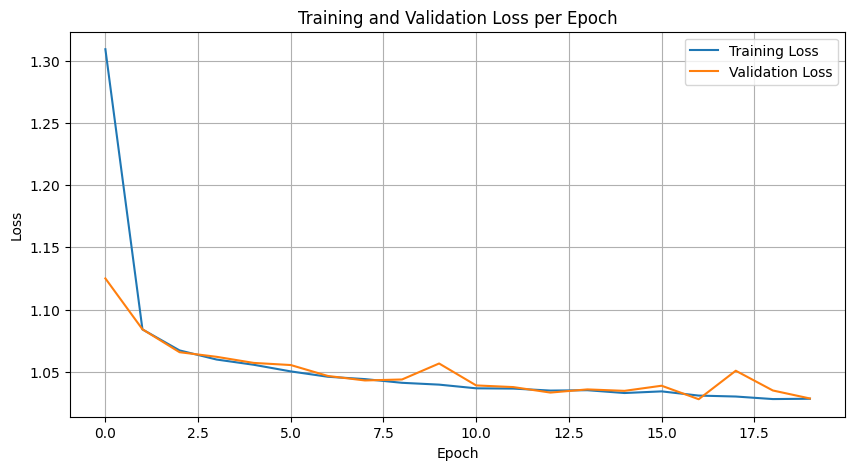

In [12]:
from tqdm import tqdm
from statistics import mean
import torch
import matplotlib.pyplot as plt

# Configuration
num_epochs = 20
folder_path_model = '../models/SAM_grayscale.pth'

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

train_losses_per_epoch = []
val_losses_per_epoch = []

# Training Loop
model.train()
for epoch in range(num_epochs):
    epoch_losses = []

    # Training loop
    for batch in tqdm(train_dataloader):
        # Forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # Compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # Backward pass (compute gradients)
        optimizer.zero_grad()
        loss.backward()

        # Optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    # Calculate mean training loss for the epoch
    mean_train_loss = mean(epoch_losses)
    train_losses_per_epoch.append(mean_train_loss)

    # Logging training results
    print(f'EPOCH: {epoch}')
    print(f'Mean training loss: {mean_train_loss}')

    # Validation loop
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            outputs = model(pixel_values=batch["pixel_values"].to(device),
                            input_boxes=batch["input_boxes"].to(device),
                            multimask_output=False)

            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))
            val_losses.append(loss.item())

    mean_val_loss = mean(val_losses)
    val_losses_per_epoch.append(mean_val_loss)
    print(f'Mean validation loss: {mean_val_loss}')

torch.save(model.state_dict(), folder_path_model)

plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses_per_epoch, label='Training Loss')
plt.plot(range(num_epochs), val_losses_per_epoch, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('training_validation_loss.png', dpi=300, bbox_inches='tight')
plt.close()
